<a href="https://colab.research.google.com/github/FatimaZahraBoujrad/phishing_classification/blob/main/content_info_class%2Bgoogle_trg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

PHISHING_PATH = "/content/drive/MyDrive/Projet_Phishing/Dataset/phishing30k.csv"
BENIGN_PATH="/content/drive/MyDrive/Projet_Phishing/Dataset/benign30k.csv"

phishing = pd.read_csv(PHISHING_PATH)
benign = pd.read_csv(BENIGN_PATH)

# Feature engineering functions

In [ ]:
def url_features(df):
    out = pd.DataFrame(index=df.index)

    out["url_length"] = df["destination_url"].fillna("").str.len()

    out["subdomain_length"] = df["subdomain"].fillna("").str.len()

    out["subdomain_token_count"] = (
        df["subdomain"]
        .fillna("")
        .apply(lambda x: len([t for t in x.split(".") if t]))
    )

    out["has_multiple_subdomains"] = out["subdomain_token_count"] > 1

    return out


In [ ]:
def url_features(df):
    out = pd.DataFrame(index=df.index)

    out["url_length"] = df["destination_url"].fillna("").str.len()

    out["subdomain_length"] = df["subdomain"].fillna("").str.len()

    out["subdomain_token_count"] = (
        df["subdomain"]
        .fillna("")
        .apply(lambda x: len([t for t in x.split(".") if t]))
    )

    out["has_multiple_subdomains"] = out["subdomain_token_count"] > 1

    return out


In [ ]:
BRAND_KEYWORDS = [
    "facebook", "meta", "google", "paypal",
    "microsoft", "apple", "amazon", "instagram"
]

URGENCY_KEYWORDS = [
    "urgent", "verify", "suspend", "restricted",
    "violation", "alert", "warning", "immediately"
]

ACTION_KEYWORDS = [
    "login", "confirm", "update", "review",
    "submit", "secure", "validate"
]


def title_features(df):
    titles = df["title"].fillna("").astype(str)
    out = pd.DataFrame(index=df.index)

    out["title_length"] = titles.str.len()

    out["title_word_count"] = titles.apply(lambda x: len(x.split()))

    out["title_unique_word_ratio"] = titles.apply(
        lambda x: len(set(x.lower().split())) / max(len(x.split()), 1)
    )

    out["title_uppercase_ratio"] = titles.apply(
        lambda x: sum(c.isupper() for c in x) / max(len(x), 1)
    )

    out["title_digit_ratio"] = titles.apply(
        lambda x: sum(c.isdigit() for c in x) / max(len(x), 1)
    )

    out["title_contains_brand"] = titles.str.lower().apply(
        lambda x: any(b in x for b in BRAND_KEYWORDS)
    )

    out["title_contains_urgency"] = titles.str.lower().apply(
        lambda x: any(u in x for u in URGENCY_KEYWORDS)
    )

    out["title_contains_action"] = titles.str.lower().apply(
        lambda x: any(a in x for a in ACTION_KEYWORDS)
    )

    return out


In [ ]:
def resource_ratio_features(df):
    out = pd.DataFrame(index=df.index)

    total = df["total_resources"].replace(0, np.nan)

    out["js_ratio"] = df["js_file_count"] / total
    out["css_ratio"] = df["css_file_count"] / total
    out["image_ratio"] = df["image_count"] / total
    out["video_ratio"] = df["video_count"] / total
    out["font_ratio"] = df["font_count"] / total

    out = out.fillna(0)

    return out


In [ ]:
def resource_dominance_features(df):
    out = pd.DataFrame(index=df.index)

    resource_cols = {
        "js": df["js_file_count"],
        "css": df["css_file_count"],
        "image": df["image_count"],
        "video": df["video_count"],
        "font": df["font_count"]
    }

    out["resource_type_dominant"] = pd.DataFrame(resource_cols).idxmax(axis=1)

    out["media_heavy_page"] = (
        (df["image_count"] + df["video_count"]) >
        (df["js_file_count"] + df["css_file_count"])
    )

    js_ratio = df["js_file_count"] / df["total_resources"].replace(0, np.nan)
    out["script_heavy_page"] = js_ratio > 0.5

    out = out.fillna(False)

    return out


In [ ]:
def resource_complexity_features(df, reuse_threshold=0.7, resource_threshold=None):
    out = pd.DataFrame(index=df.index)

    total = df["total_resources"].replace(0, np.nan)

    out["resource_reuse_ratio"] = df["unique_md5_hashes"] / total

    out["has_high_reuse"] = out["resource_reuse_ratio"] < reuse_threshold

    out["resource_density"] = total / df["unique_file_types"].replace(0, np.nan)

    if resource_threshold is None:
        resource_threshold = df["total_resources"].median()

    out["low_diversity_high_count"] = (
        (df["total_resources"] > resource_threshold) &
        (df["unique_file_types"] <= 2)
    )

    out = out.fillna(0)

    return out


In [ ]:
def tech_features(df):
    tech = df["tech_info"].fillna("").str.lower()
    out = pd.DataFrame(index=df.index)

    out["tech_info_missing"] = tech == ""

    out["uses_php"] = tech.str.contains("php")
    out["uses_node"] = tech.str.contains("node|express")
    out["uses_react"] = tech.str.contains("react")
    out["uses_tailwind"] = tech.str.contains("tailwind")
    out["uses_static_host"] = tech.str.contains(
        "surge|netlify|vercel|github|static"
    )

    return out


In [ ]:
# Add labels
phishing_labeled = phishing.copy()
phishing_labeled["label"] = 1   # 1 = phishing

benign_labeled = benign.copy()
benign_labeled["label"] = 0     # 0 = benign

# Combine datasets
combined_df = pd.concat(
    [phishing_labeled, benign_labeled],
    axis=0,
    ignore_index=True
)

# Optional: shuffle rows
combined_df = combined_df.sample(frac=1, random_state=42).reset_index(drop=True)

print(combined_df.shape)
combined_df.head()


(59590, 53)


,url,is_https,dns_a_status,dns_a_answer_1,dns_aaaa_status,dns_mx_status,ssl_issuer,ssl_valid_from,ssl_valid_until,ssl_is_valid_cert,...,rd_has_ip,sd_has_ip,attack_pattern_ip,has_history,subdomain_len,tld,is_common_tld,trg,fqdn,label
0,https://monitoringpublic.solaredge.com/mfe/reg...,True,NOERROR,167.86.50.129,NOERROR,NOERROR,DigiCert Inc,2024-04-01,2025-05-02,True,...,1,1,0,0,16,com,1,NaN,monitoringpublic.solaredge.com,0
1,https://www.tempo.pt/bombarral.htm,True,NOERROR,104.18.166.107,NOERROR,NOERROR,Google Trust Services,2025-02-04,2025-05-05,True,...,1,0,0,0,4,pt,0,NaN,www.tempo.pt,0
2,https://shaw-108007.weeblysite.com/,True,NOERROR,74.115.51.54,NOERROR,NOERROR,"Cloudflare, Inc.",2023-09-29,2024-09-27,True,...,1,1,0,0,11,com,1,Other,shaw-108007.weeblysite.com,1
3,https://tflvru.postalii.shop/,True,NOERROR,188.114.96.3,NOERROR,NOERROR,Google Trust Services,2024-07-05,2024-10-03,True,...,1,1,0,0,6,shop,0,National Police Agency JAPAN,tflvru.postalii.shop,1
4,https://domotz.com/press/magnolia-at-best-buy-...,True,NOERROR,18.245.86.119,NOERROR,NOERROR,Amazon,2024-09-15,2025-10-12,True,...,1,0,0,0,4,com,1,NaN,domotz.com,0


In [ ]:
url_df = url_features(combined_df)
title_df = title_features(combined_df)
ratio_df = resource_ratio_features(combined_df)
dominance_df = resource_dominance_features(combined_df)
complexity_df = resource_complexity_features(combined_df)
tech_df = tech_features(combined_df)


<Figure size 640x480 with 0 Axes>

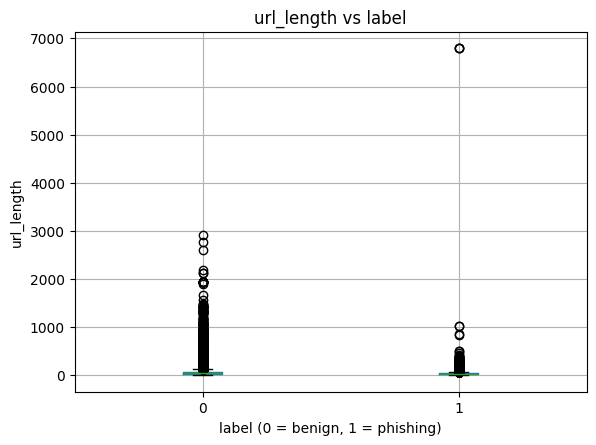

<Figure size 640x480 with 0 Axes>

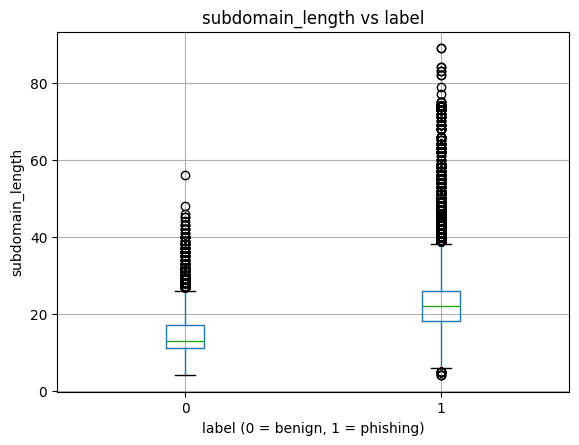

<Figure size 640x480 with 0 Axes>

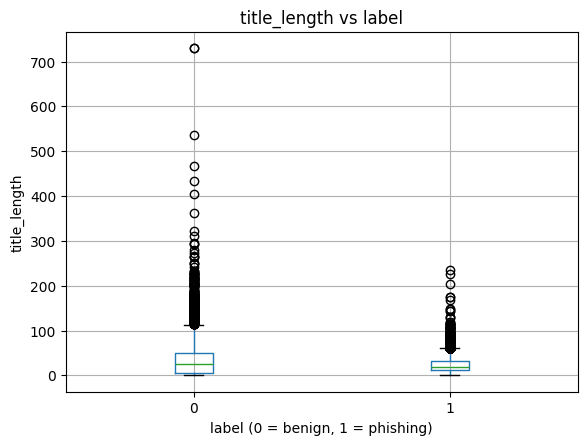

<Figure size 640x480 with 0 Axes>

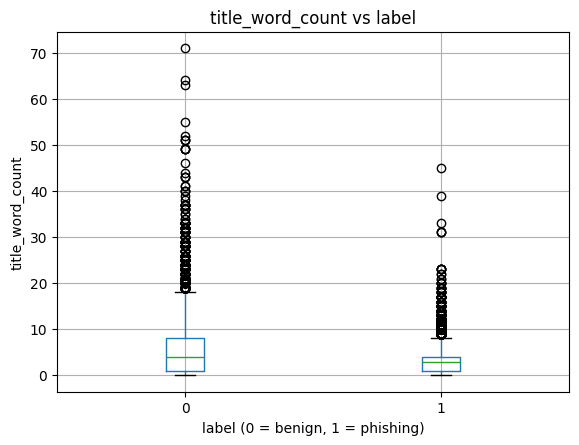

<Figure size 640x480 with 0 Axes>

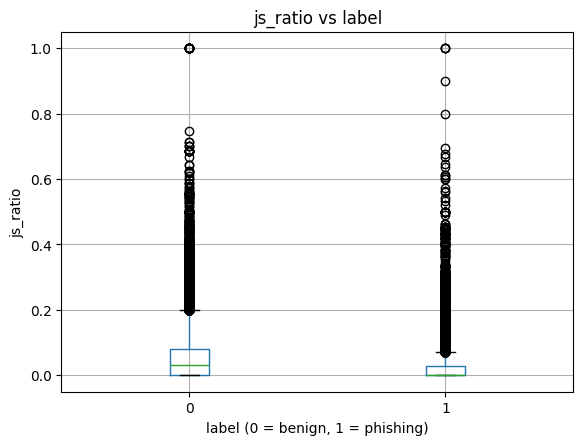

<Figure size 640x480 with 0 Axes>

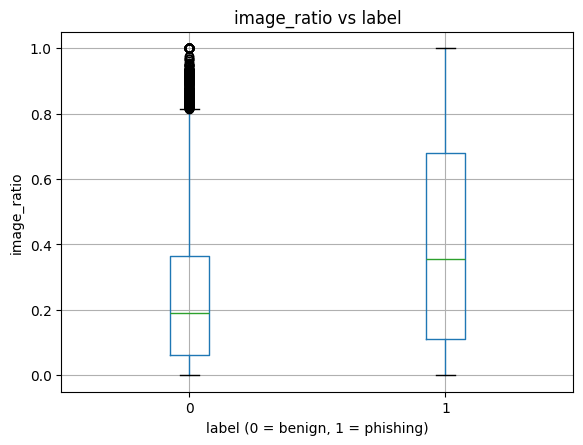

<Figure size 640x480 with 0 Axes>

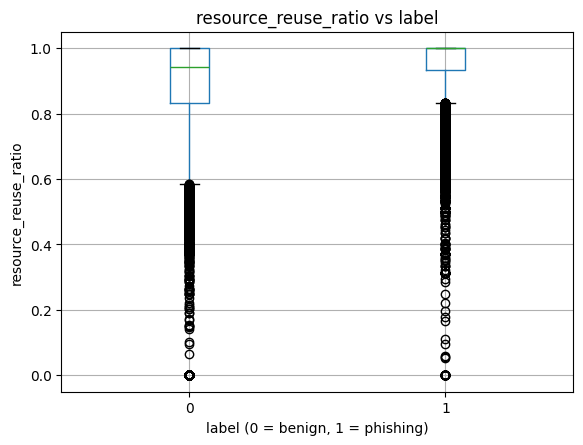

<Figure size 640x480 with 0 Axes>

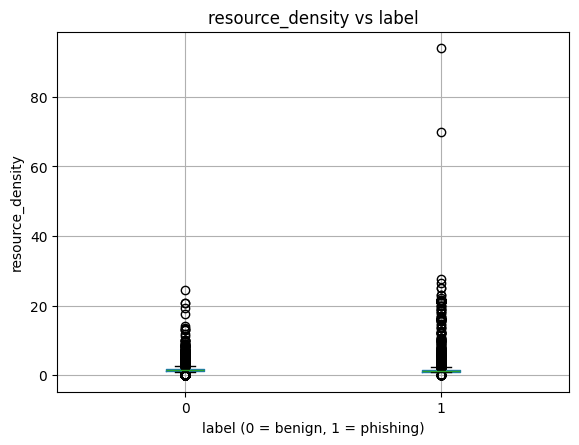

In [ ]:
# Simple EDA plots to check feature impact on classification
# Assumes phishing and benign DataFrames already exist

import matplotlib.pyplot as plt
import pandas as pd

# Re-create combined_df safely
phishing_labeled = phishing.copy()
phishing_labeled["label"] = 1

benign_labeled = benign.copy()
benign_labeled["label"] = 0

combined_df = pd.concat(
    [phishing_labeled, benign_labeled],
    axis=0,
    ignore_index=True
)

# Feature DataFrames (already computed by you)
url_df = url_features(combined_df)
title_df = title_features(combined_df)
ratio_df = resource_ratio_features(combined_df)
complexity_df = resource_complexity_features(combined_df)

# Temporary merge ONLY for EDA
eda_df = pd.concat(
    [
        combined_df[["label"]],
        url_df,
        title_df,
        ratio_df,
        complexity_df,
    ],
    axis=1
)

# Numeric features to visualize
features_to_plot = [
    "url_length",
    "subdomain_length",
    "title_length",
    "title_word_count",
    "js_ratio",
    "image_ratio",
    "resource_reuse_ratio",
    "resource_density",
]

# Boxplots by class
for feature in features_to_plot:
    plt.figure()
    eda_df.boxplot(column=feature, by="label")
    plt.title(f"{feature} vs label")
    plt.suptitle("")
    plt.xlabel("label (0 = benign, 1 = phishing)")
    plt.ylabel(feature)
    plt.show()


In [ ]:
eda_df = pd.concat(
    [
        combined_df[["label"]],
        url_df,
        title_df,
        ratio_df,
        dominance_df,
        complexity_df,
        tech_df,
    ],
    axis=1
)


In [ ]:
binary_features = [
    "has_multiple_subdomains",
    "title_contains_brand",
    "title_contains_urgency",
    "title_contains_action",
    "media_heavy_page",
    "script_heavy_page",
    "has_high_reuse",
    "tech_info_missing",
    "uses_php",
    "uses_node",
    "uses_static_host",
    "uses_tailwind",
    "uses_react",
]

binary_summary = (
    eda_df.groupby("label")[binary_features]
    .mean()
    .T
)

binary_summary


label,0,1
has_multiple_subdomains,1.000000,1.000000
title_contains_brand,0.042201,0.131831
title_contains_urgency,0.001367,0.002399
title_contains_action,0.040235,0.044304
media_heavy_page,0.748292,0.749282
script_heavy_page,0.002033,0.001723
has_high_reuse,0.062035,0.064006
tech_info_missing,0.393746,0.384103
uses_php,0.092170,0.094421
uses_node,0.001467,0.001960


In [ ]:
boolean_features_df = pd.concat(
    [
        combined_df[["label"]],
        title_df[[
            "title_contains_brand",
            "title_contains_urgency",
        ]],
        complexity_df[[
            "has_high_reuse",
        ]],
        tech_df[[
            "uses_php",
        ]],
    ],
    axis=1
)


In [ ]:
boolean_features_df.mean()


,0
label,0.496577
title_contains_brand,0.086709
title_contains_urgency,0.001880
has_high_reuse,0.063014
uses_php,0.093287


In [ ]:
# Select numeric / ratio features
numeric_features = [
    "url_length",
    "subdomain_length",
    "subdomain_token_count",
    "css_ratio",
    "image_ratio",
    "video_ratio",
    "font_ratio",
    "title_length",
    "title_word_count",
    "title_unique_word_ratio",
    "title_uppercase_ratio",
    "title_digit_ratio",
    "resource_reuse_ratio",
    "file_type_diversity_score",
    "total_resources",
    "unique_file_types",
]

# Boolean features from EDA + original dataset
boolean_features = [
    "title_contains_brand",
    "title_contains_urgency",
    "has_high_reuse",
    "uses_php",
    "has_path",
    "has_duplicate_resources",
    "has_video",
    "has_audio",
    "has_subdomain",
]

# Merge all features
final_df = pd.concat(
    [
        combined_df[["label"]],
        url_df,          # url_length, subdomain_length, subdomain_token_count
        title_df[["title_length", "title_word_count", "title_unique_word_ratio",
                  "title_uppercase_ratio", "title_digit_ratio",
                  "title_contains_brand", "title_contains_urgency"]],
        ratio_df[[ "image_ratio", "font_ratio"]],
        complexity_df[["resource_reuse_ratio", "has_high_reuse"]],
        tech_df[["uses_php"]],
        combined_df[["has_path", "has_duplicate_resources",  "has_audio", "has_subdomain"]],
        combined_df[["total_resources", "unique_file_types", "file_type_diversity_score"]],
    ],
    axis=1
)

print(final_df.shape)
final_df.head()


(59590, 24)


,label,url_length,subdomain_length,subdomain_token_count,has_multiple_subdomains,title_length,title_word_count,title_unique_word_ratio,title_uppercase_ratio,title_digit_ratio,...,resource_reuse_ratio,has_high_reuse,uses_php,has_path,has_duplicate_resources,has_audio,has_subdomain,total_resources,unique_file_types,file_type_diversity_score
0,1,27,18,3,True,32,4,1.0,0.093750,0.0,...,1.0,False,False,False,False,False,True,3,3,1.000
1,1,109,19,2,True,17,3,1.0,0.176471,0.0,...,1.0,False,False,True,False,False,False,9,9,1.000
2,1,39,31,3,True,12,2,1.0,0.166667,0.0,...,1.0,False,False,False,False,False,True,4,4,1.000
3,1,25,10,2,True,0,0,0.0,0.000000,0.0,...,1.0,False,False,True,False,False,False,20,19,0.950
4,1,30,21,3,True,49,7,1.0,0.122449,0.0,...,1.0,False,True,False,False,False,True,29,23,0.793


In [ ]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59590 entries, 0 to 59589
Data columns (total 24 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   label                      59590 non-null  int64  
 1   url_length                 59590 non-null  int64  
 2   subdomain_length           59590 non-null  int64  
 3   subdomain_token_count      59590 non-null  int64  
 4   has_multiple_subdomains    59590 non-null  bool   
 5   title_length               59590 non-null  int64  
 6   title_word_count           59590 non-null  int64  
 7   title_unique_word_ratio    59590 non-null  float64
 8   title_uppercase_ratio      59590 non-null  float64
 9   title_digit_ratio          59590 non-null  float64
 10  title_contains_brand       59590 non-null  bool   
 11  title_contains_urgency     59590 non-null  bool   
 12  image_ratio                59590 non-null  float64
 13  font_ratio                 59590 non-null  flo

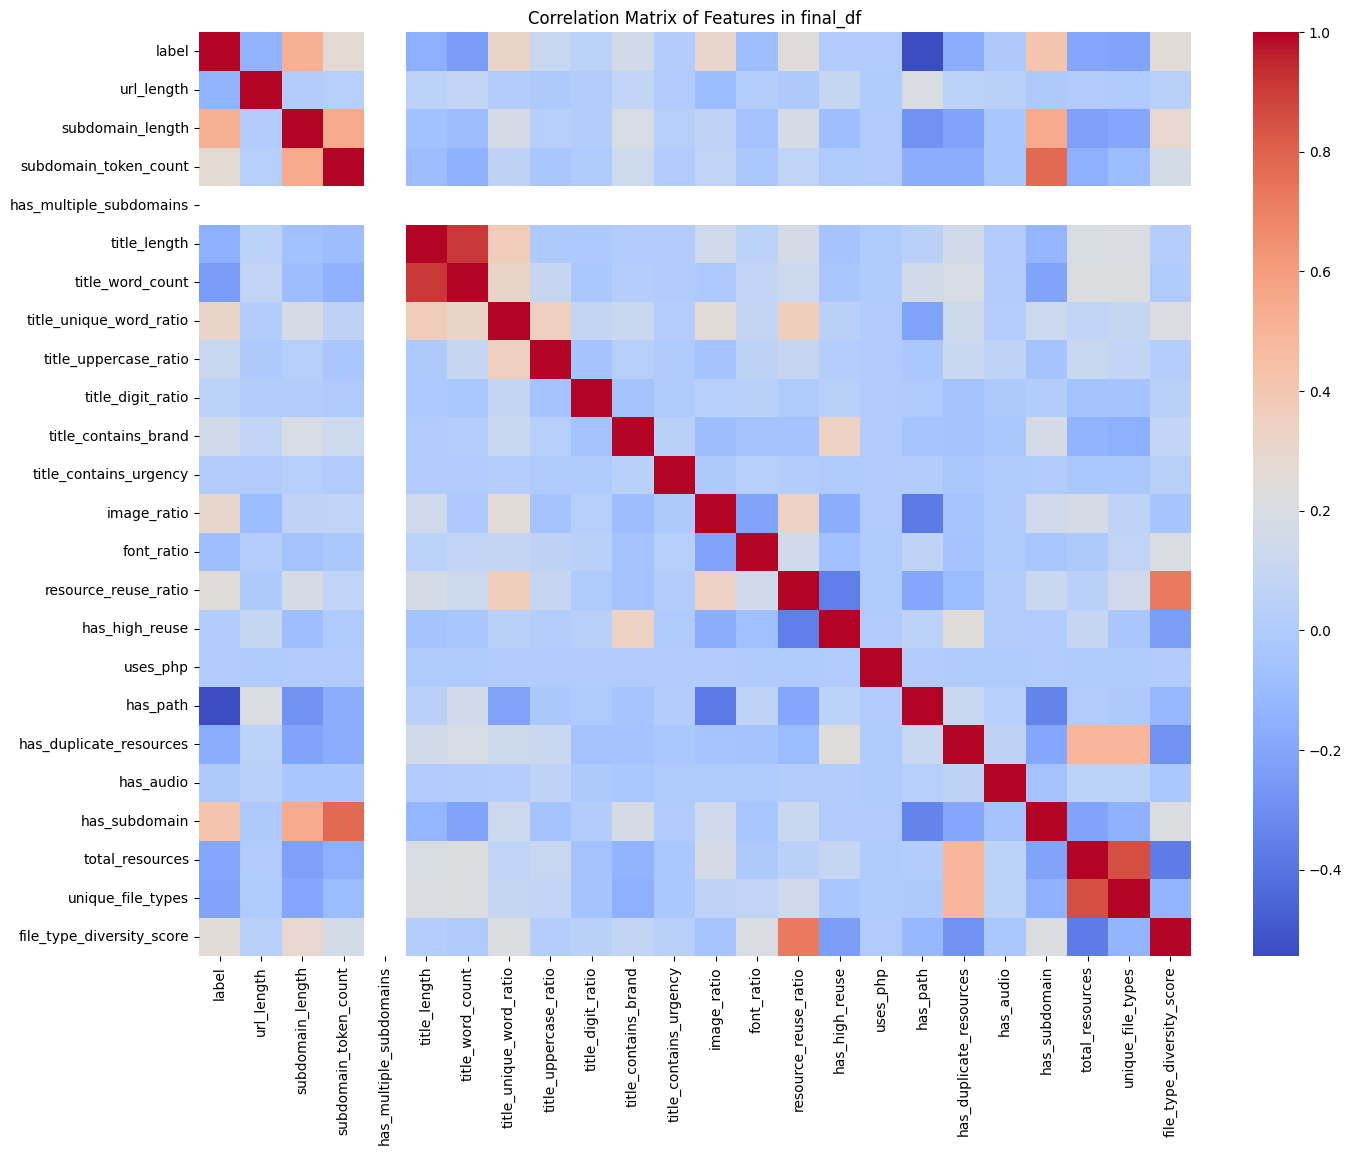

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the correlation matrix
correlation_matrix = final_df.corr(numeric_only=True)

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Features in final_df')
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Target
y = final_df["label"]

# Features
X = final_df.drop(columns=["label"])


In [ ]:
# Convert all boolean columns to int
bool_cols = X.select_dtypes(include="bool").columns
X[bool_cols] = X[bool_cols].astype(int)


In [ ]:
# Numeric columns (float or int, excluding boolean features)
numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns.difference(bool_cols)

scaler = StandardScaler()
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training set:", X_train.shape)
print("Test set:", X_test.shape)


Training set: (47672, 23)
Test set: (11918, 23)


# Modeling

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
# Logistic Regression
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)

print("=== Logistic Regression ===")
print(classification_report(y_test, y_pred_lr))


=== Logistic Regression ===
              precision    recall  f1-score   support

           0       0.88      0.89      0.88      6000
           1       0.89      0.87      0.88      5918

    accuracy                           0.88     11918
   macro avg       0.88      0.88      0.88     11918
weighted avg       0.88      0.88      0.88     11918



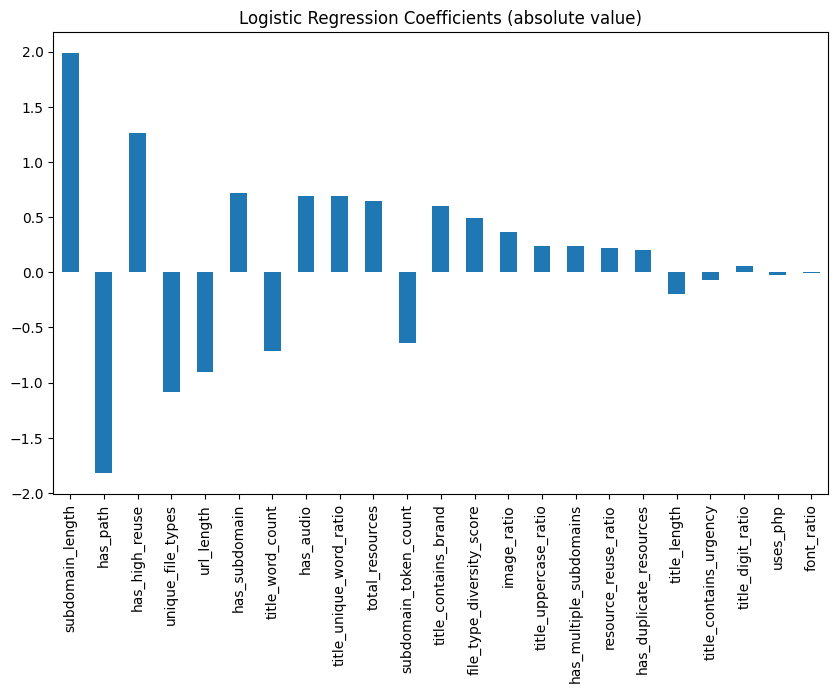

In [ ]:
coefficients = pd.Series(lr.coef_[0], index=X.columns).sort_values(key=abs, ascending=False)
plt.figure(figsize=(10,6))
coefficients.plot(kind="bar")
plt.title("Logistic Regression Coefficients (absolute value)")
plt.show()


In [ ]:
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

print("=== Random Forest ===")
print(classification_report(y_test, y_pred_rf))


=== Random Forest ===
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      6000
           1       0.98      0.96      0.97      5918

    accuracy                           0.97     11918
   macro avg       0.97      0.97      0.97     11918
weighted avg       0.97      0.97      0.97     11918



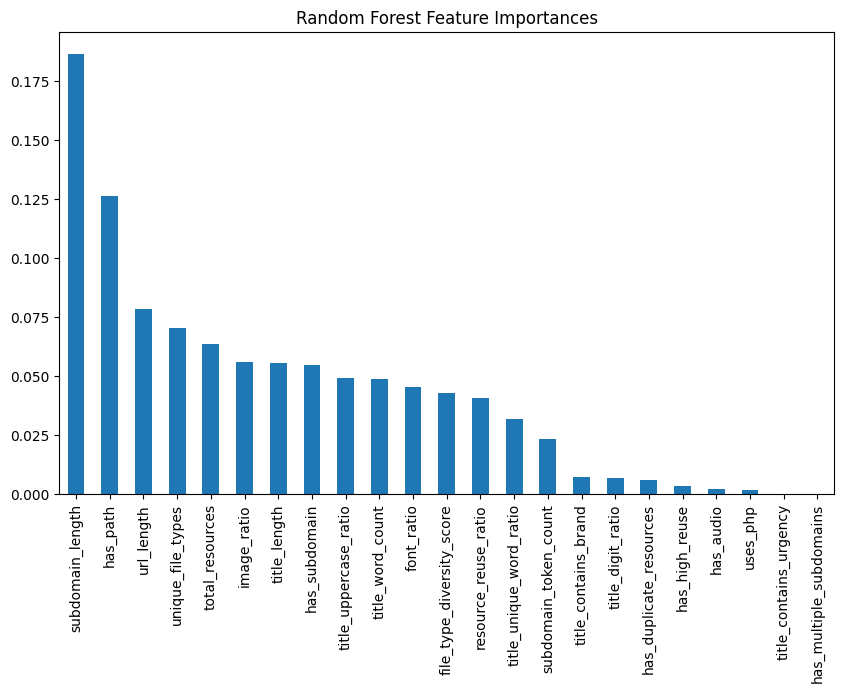

In [ ]:
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10,6))
importances.plot(kind="bar")
plt.title("Random Forest Feature Importances")
plt.show()


In [ ]:
xgb = XGBClassifier(n_estimators=200, random_state=42, use_label_encoder=False, eval_metric="logloss")
xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test)

print("=== XGBoost ===")
print(classification_report(y_test, y_pred_xgb))


=== XGBoost ===
              precision    recall  f1-score   support

           0       0.92      0.89      0.90       100
           1       0.89      0.92      0.91       100

    accuracy                           0.91       200
   macro avg       0.91      0.91      0.90       200
weighted avg       0.91      0.91      0.90       200



/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:32:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


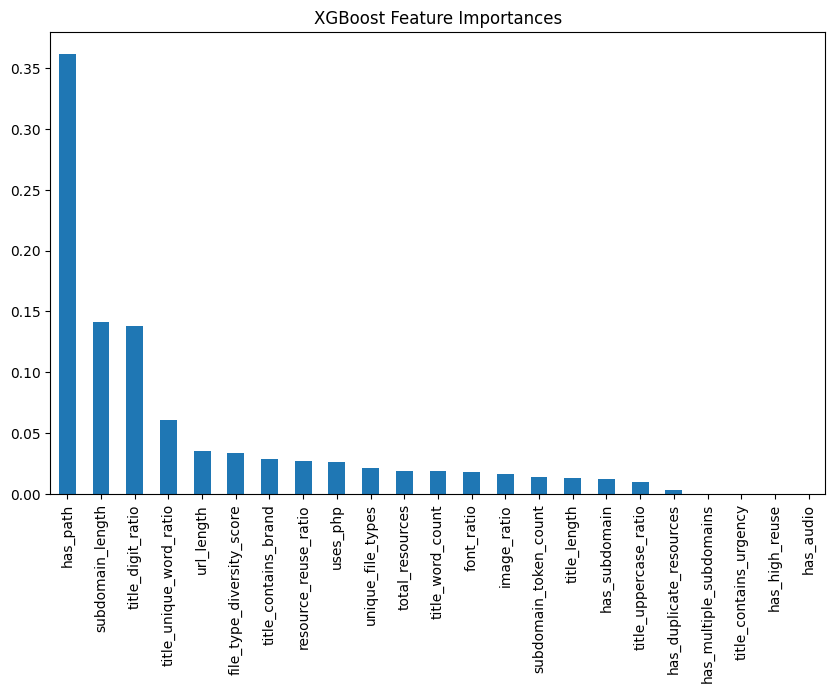

In [ ]:
xgb_importances = pd.Series(xgb.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10,6))
xgb_importances.plot(kind="bar")
plt.title("XGBoost Feature Importances")
plt.show()


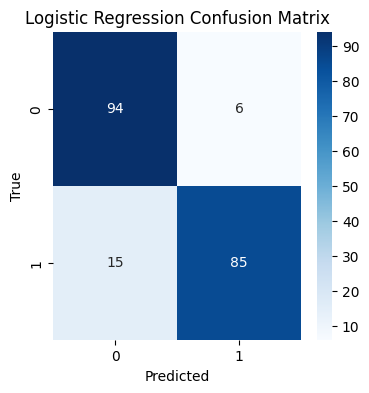

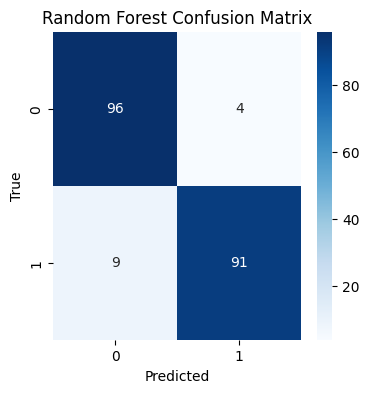

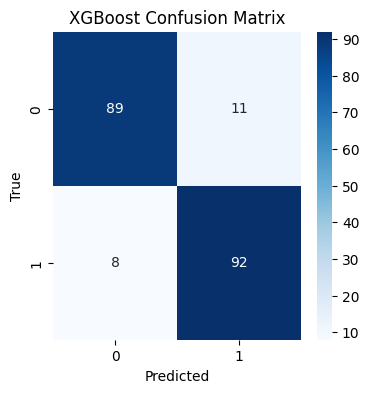

In [ ]:
models = {"Logistic Regression": y_pred_lr, "Random Forest": y_pred_rf, "XGBoost": y_pred_xgb}

for name, y_pred in models.items():
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [200, 500, 1000],
    'max_depth': [10, 20, None],
    'min_samples_leaf': [1, 2, 5],
    'max_features': ['sqrt', 'log2', None]
}

grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='f1')
grid.fit(X_train, y_train)

print(grid.best_params_)


KeyboardInterrupt: 

In [ ]:
!pip install mlxtend


In [ ]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.ensemble import RandomForestClassifier


In [ ]:
# Random Forest comme estimateur
rf = RandomForestClassifier(n_estimators=200, random_state=42)

# Forward selection
sfs = SFS(rf,
          k_features='best',   # On peut mettre un nombre max si on veut limiter
          forward=True,
          floating=False,      # Si True, permet d'enlever une feature si elle devient inutile
          scoring='f1',        # F1-score comme métrique
          cv=5,                # 5-fold cross-validation
          n_jobs=-1)           # Utilise tous les coeurs


In [ ]:
sfs = sfs.fit(X_train, y_train)


In [ ]:
selected_features = list(sfs.k_feature_names_)
print("Features sélectionnées :", selected_features)


Features sélectionnées : ['url_length', 'subdomain_length', 'subdomain_token_count', 'has_multiple_subdomains', 'title_word_count', 'title_unique_word_ratio', 'title_uppercase_ratio', 'title_contains_brand', 'title_contains_urgency', 'image_ratio', 'font_ratio', 'resource_reuse_ratio', 'has_high_reuse', 'uses_php', 'has_path', 'has_duplicate_resources', 'has_audio', 'has_subdomain', 'total_resources', 'unique_file_types']


In [ ]:
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]


In [ ]:
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]


In [ ]:
rf_final = RandomForestClassifier(n_estimators=200, random_state=42)
rf_final.fit(X_train_selected, y_train)
y_pred_final = rf_final.predict(X_test_selected)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_final))


              precision    recall  f1-score   support

           0       0.93      0.96      0.95       100
           1       0.96      0.93      0.94       100

    accuracy                           0.94       200
   macro avg       0.95      0.95      0.94       200
weighted avg       0.95      0.94      0.94       200



# Increasing dataset
To improve results we will try increasing data points up to 29k


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

PHISHING_PATH = "/content/drive/MyDrive/Dataset/phishing30k.csv"
BENIGN_PATH="/content/drive/MyDrive/Dataset/benign30k.csv"

phishing = pd.read_csv(PHISHING_PATH)
benign = pd.read_csv(BENIGN_PATH)

In [ ]:
phishing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29591 entries, 0 to 29590
Data columns (total 52 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   url                                 29591 non-null  object 
 1   is_https                            29591 non-null  bool   
 2   dns_a_status                        29591 non-null  object 
 3   dns_a_answer_1                      29586 non-null  object 
 4   dns_aaaa_status                     29591 non-null  object 
 5   dns_mx_status                       29591 non-null  object 
 6   ssl_issuer                          27781 non-null  object 
 7   ssl_valid_from                      27781 non-null  object 
 8   ssl_valid_until                     27781 non-null  object 
 9   ssl_is_valid_cert                   29591 non-null  bool   
 10  maxmind_1_ip                        29586 non-null  object 
 11  maxmind_1_asn_code                  29582

In [ ]:
benign.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29999 entries, 0 to 29998
Data columns (total 52 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   url                                 29999 non-null  object 
 1   is_https                            29999 non-null  bool   
 2   dns_a_status                        29999 non-null  object 
 3   dns_a_answer_1                      29957 non-null  object 
 4   dns_aaaa_status                     29999 non-null  object 
 5   dns_mx_status                       29999 non-null  object 
 6   ssl_issuer                          29624 non-null  object 
 7   ssl_valid_from                      29624 non-null  object 
 8   ssl_valid_until                     29624 non-null  object 
 9   ssl_is_valid_cert                   29999 non-null  bool   
 10  maxmind_1_ip                        29957 non-null  object 
 11  maxmind_1_asn_code                  29863

## Lets add another feature as well: the target
we want to compare the target of the phishing website to the brand on the url and see if they match.
Malicious websites can imitate a brand like paypal but not a paypal domain!

In [ ]:
#benign website there is always a match
benign['trg_mismatch']=1

In [ ]:
print(benign['trg_mismatch'].value_counts())

trg_mismatch
1    29999
Name: count, dtype: int64


In [ ]:
!pip install tldextract

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.4/107.4 kB 6.0 MB/s eta 0:00:00


In [ ]:
import tldextract

def brand_url_match(trg: str, url: str) -> int:
    if not trg or not url:
        return 0

    brand = trg.lower().strip()
    ext = tldextract.extract(url)

    # domaine enregistré (ex: meta.com → domain = meta)
    domain = ext.domain.lower() if ext.domain else ""

    return int(brand == domain)


In [ ]:
print(benign[['url','title']])

                                                 url  \
0     https://box.com/departments/finance-accounting   
1  https://vnexpress.net/nguoi-dan-dong-loat-giao...   
2                             https://www.tomsk.ru/1   
3  https://nutrition.org/upcoming-webinars-using-...   
4  https://www.antstream.com/profile/d0334cb4-e96...   

                                               title  
0           Box for Finance - Drive Financial Growth  
1                                                NaN  
2                                                NaN  
3  Upcoming Webinars: Using National Health and N...  
4                                                NaN  


In [ ]:
phishing['trg_mismatch'] = phishing.apply(lambda row: brand_url_match(row['trg'], row['fqdn']), axis=1)

In [ ]:
print(phishing['trg_mismatch'].value_counts())


trg_mismatch
0    29583
1        8
Name: count, dtype: int64


In [ ]:
phishing["trg"].value_counts().head(30)


,count
trg,
Other,10089
National Police Agency JAPAN,8489
Facebook,3271
USPS,1745
Meta,1166
WhatsApp,1008
AT&T,638
Instagram,303
google,199


In [ ]:
phishing[['trg','fqdn','url']].head(30)

,trg,fqdn,url
0,National Police Agency JAPAN,xcbmut.hgfosb.shop,https://xcbmut.hgfosb.shop/
1,SwissPass,ultrananoshield.com,https://ultrananoshield.com/wp-includes/ID3/re...
2,Meta,reveiw--new--violation.surge.sh,http://reveiw--new--violation.surge.sh/
3,Other,indai.live,https://indai.live/track/
4,Other,matamaskio.weebly.com,https://matamaskio.weebly.com/
5,Other,dinasa2070.wixstudio.io,https://dinasa2070.wixstudio.io/my-site-1
6,Alpargatas,quiz-collabhavaianas.online,https://quiz-collabhavaianas.online/quiz
7,Other,trezoris-io-start.webflow.io,http://trezoris-io-start.webflow.io
8,National Police Agency JAPAN,xvwfm.pollosloreto.com,https://xvwfm.pollosloreto.com/
9,Other,brandingatt.weebly.com,https://brandingatt.weebly.com/


In [ ]:
benign["fqdn"].isnull().sum()

np.int64(0)

In [ ]:
benign[["fqdn","url"]].head(30)

,fqdn,url
0,gq-magazine.co.uk,https://gq-magazine.co.uk/profile/molly-lambert
1,53kf.com,https://53kf.com/login/guide?url=http://www.53...
2,gamerxyt.com,https://gamerxyt.com
3,www.underarmour.com,https://www.underarmour.com/en-us/track-order/
4,jpg5.su,https://jpg5.su/lib/Peafowl/peafowl.min.js?8d1...
5,www.lib.ncsu.edu,https://www.lib.ncsu.edu/user/login
6,pagbank.onelink.me,https://pagbank.onelink.me/Dzpm?pid=midia-interna
7,nanit.com,https://nanit.com/pages/payment-options
8,box.com,https://box.com/departments/finance-accounting
9,vnexpress.net,https://vnexpress.net/nguoi-dan-dong-loat-giao...


In [ ]:
benign['fqdn'].value_counts().head(30)

,count
fqdn,
accounts.google.com,411
bsky.app,136
www.beian.gov.cn,78
www.facebook.com,64
www.linkedin.com,53
support.google.com,45
public.govdelivery.com,35
www.cloudflare.com,31
www.microsoft.com,28


In [ ]:
phishing['trg'].value_counts().head(30)

,count
trg,
Other,10089
National Police Agency JAPAN,8489
Facebook,3271
USPS,1745
Meta,1166
WhatsApp,1008
AT&T,638
Instagram,303
google,199


In [ ]:
import tldextract

def fqdn_to_brand(fqdn: str) -> str | None:
    if not fqdn:
        return None

    ext = tldextract.extract(fqdn)
    return ext.domain.lower() if ext.domain else None


ModuleNotFoundError: No module named 'tldextract'

In [ ]:
benign["brand"] = benign["fqdn"].apply(fqdn_to_brand)

benign["brand"].value_counts().head(20)


,count
brand,
google,774
bsky,136
amazon,103
beian,78
facebook,73
microsoft,57
linkedin,56
apple,55
flashscore,51


In [ ]:
benign['label']=0
phishing['label']=1

# Combine datasets
combined_df = pd.concat(
    [phishing, benign],
    axis=0,
    ignore_index=True
)

# Optional: shuffle rows
combined_df = combined_df.sample(frac=1, random_state=42).reset_index(drop=True)

print(combined_df.shape)
combined_df.head()

(59590, 54)


,url,is_https,dns_a_status,dns_a_answer_1,dns_aaaa_status,dns_mx_status,ssl_issuer,ssl_valid_from,ssl_valid_until,ssl_is_valid_cert,...,sd_has_ip,attack_pattern_ip,has_history,subdomain_len,tld,is_common_tld,trg,fqdn,trg_mismatch,label
0,https://monitoringpublic.solaredge.com/mfe/reg...,True,NOERROR,167.86.50.129,NOERROR,NOERROR,DigiCert Inc,2024-04-01,2025-05-02,True,...,1,0,0,16,com,1,NaN,monitoringpublic.solaredge.com,1,0
1,https://www.tempo.pt/bombarral.htm,True,NOERROR,104.18.166.107,NOERROR,NOERROR,Google Trust Services,2025-02-04,2025-05-05,True,...,0,0,0,4,pt,0,NaN,www.tempo.pt,1,0
2,https://shaw-108007.weeblysite.com/,True,NOERROR,74.115.51.54,NOERROR,NOERROR,"Cloudflare, Inc.",2023-09-29,2024-09-27,True,...,1,0,0,11,com,1,Other,shaw-108007.weeblysite.com,0,1
3,https://tflvru.postalii.shop/,True,NOERROR,188.114.96.3,NOERROR,NOERROR,Google Trust Services,2024-07-05,2024-10-03,True,...,1,0,0,6,shop,0,National Police Agency JAPAN,tflvru.postalii.shop,0,1
4,https://domotz.com/press/magnolia-at-best-buy-...,True,NOERROR,18.245.86.119,NOERROR,NOERROR,Amazon,2024-09-15,2025-10-12,True,...,0,0,0,4,com,1,NaN,domotz.com,1,0


In [ ]:
print(combined_df['label'].value_counts())

label
0    29999
1    29591
Name: count, dtype: int64


In [ ]:
phishing_df = combined_df[combined_df['label'] == 1]
benign_df = combined_df[combined_df['label'] == 0]

# Determine the size of the minority class
minority_class_size = len(phishing_df)

# Undersample the majority class
benign_undersampled = benign_df.sample(n=minority_class_size, random_state=42)

# Combine the undersampled benign and phishing dataframes
combined_df_balanced = pd.concat([phishing_df, benign_undersampled], axis=0)

# Shuffle the balanced dataframe
combined_df_balanced = combined_df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print("New class distribution:")
print(combined_df_balanced['label'].value_counts())

New class distribution:
label
0    29591
1    29591
Name: count, dtype: int64


## Feature enineering

In [ ]:
url_df = url_features(combined_df)
title_df = title_features(combined_df)
ratio_df = resource_ratio_features(combined_df)
dominance_df = resource_dominance_features(combined_df)
complexity_df = resource_complexity_features(combined_df)
tech_df = tech_features(combined_df)


<Figure size 640x480 with 0 Axes>

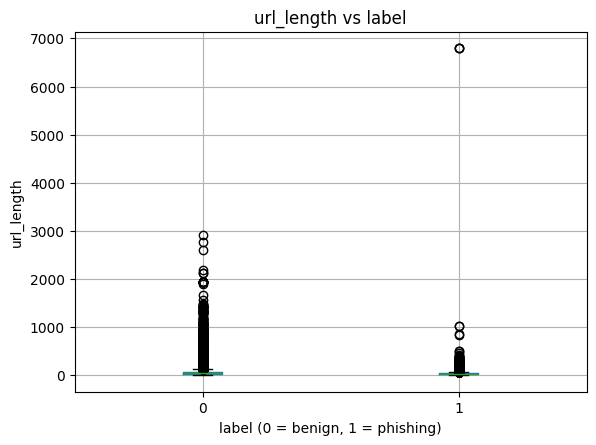

<Figure size 640x480 with 0 Axes>

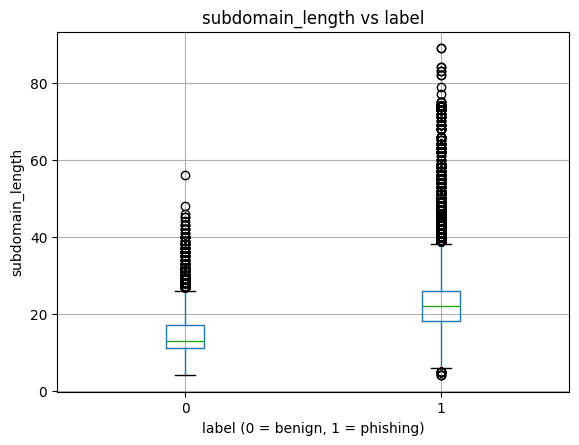

<Figure size 640x480 with 0 Axes>

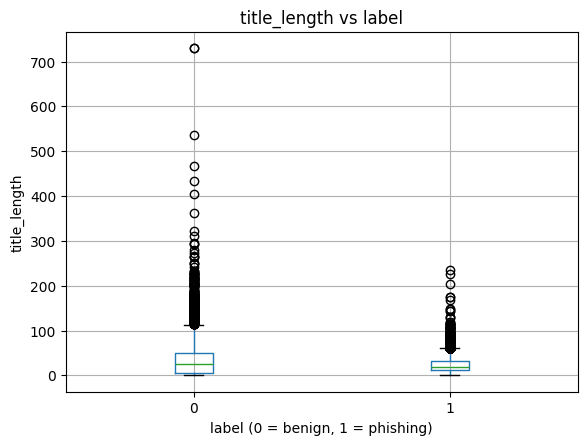

<Figure size 640x480 with 0 Axes>

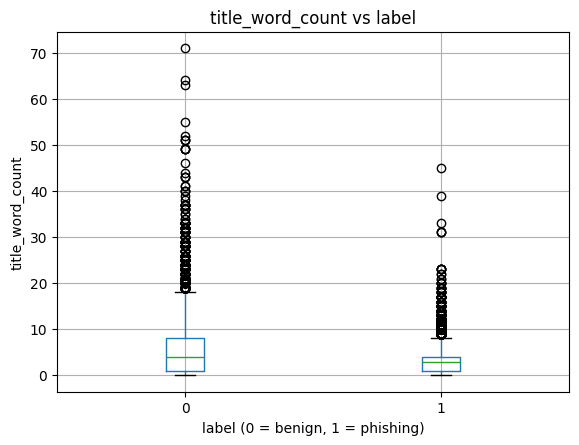

<Figure size 640x480 with 0 Axes>

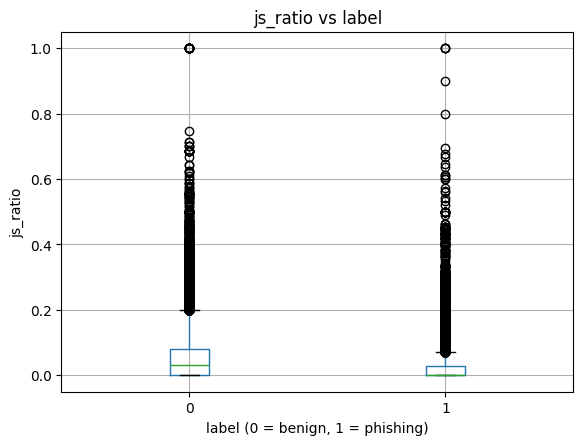

<Figure size 640x480 with 0 Axes>

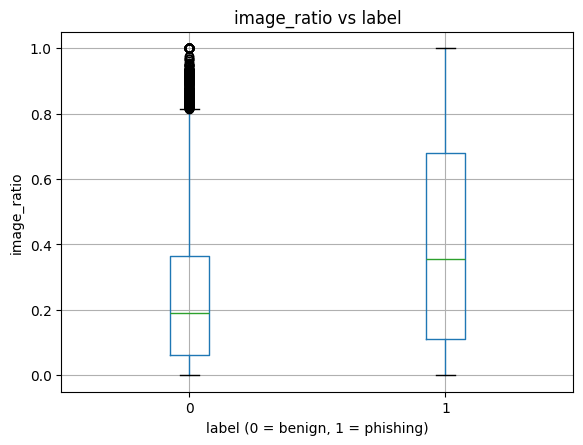

<Figure size 640x480 with 0 Axes>

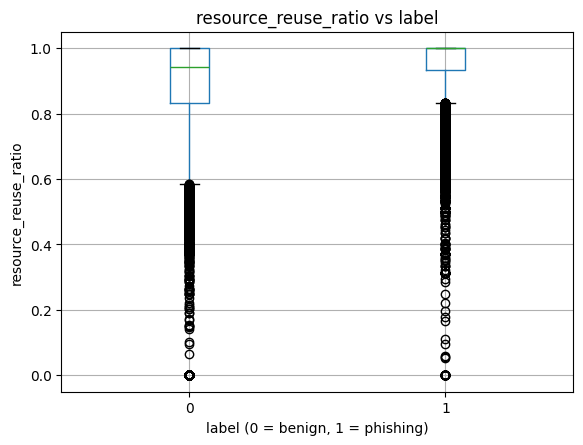

<Figure size 640x480 with 0 Axes>

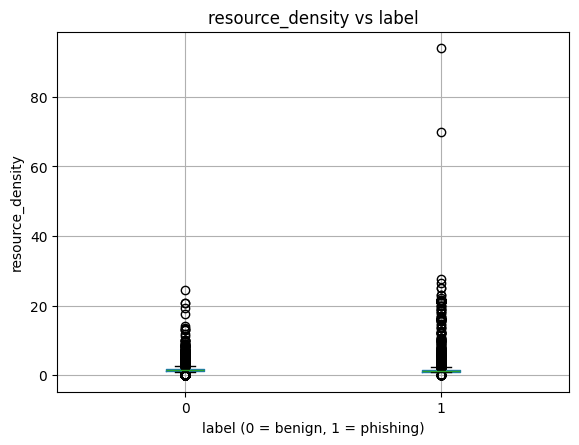

In [ ]:
# Simple EDA plots to check feature impact on classification
# Assumes phishing and benign DataFrames already exist

import matplotlib.pyplot as plt
import pandas as pd

# Re-create combined_df safely
phishing_labeled = phishing.copy()
phishing_labeled["label"] = 1

benign_labeled = benign.copy()
benign_labeled["label"] = 0

combined_df = pd.concat(
    [phishing_labeled, benign_labeled],
    axis=0,
    ignore_index=True
)

# Feature DataFrames (already computed by you)
url_df = url_features(combined_df)
title_df = title_features(combined_df)
ratio_df = resource_ratio_features(combined_df)
complexity_df = resource_complexity_features(combined_df)

# Temporary merge ONLY for EDA
eda_df = pd.concat(
    [
        combined_df[["label"]],
        url_df,
        title_df,
        ratio_df,
        complexity_df,
    ],
    axis=1
)

# Numeric features to visualize
features_to_plot = [
    "url_length",
    "subdomain_length",
    "title_length",
    "title_word_count",
    "js_ratio",
    "image_ratio",
    "resource_reuse_ratio",
    "resource_density",
]

# Boxplots by class
for feature in features_to_plot:
    plt.figure()
    eda_df.boxplot(column=feature, by="label")
    plt.title(f"{feature} vs label")
    plt.suptitle("")
    plt.xlabel("label (0 = benign, 1 = phishing)")
    plt.ylabel(feature)
    plt.show()


In [ ]:
eda_df = pd.concat(
    [
        combined_df[["label"]],
        url_df,
        title_df,
        ratio_df,
        dominance_df,
        complexity_df,
        tech_df,
    ],
    axis=1
)


In [ ]:
binary_features = [
    "has_multiple_subdomains",
    "title_contains_brand",
    "title_contains_urgency",
    "title_contains_action",
    "media_heavy_page",
    "script_heavy_page",
    "has_high_reuse",
    "tech_info_missing",
    "uses_php",
    "uses_node",
    "uses_static_host",
    "uses_tailwind",
    "uses_react",
]

binary_summary = (
    eda_df.groupby("label")[binary_features]
    .mean()
    .T
)

binary_summary


label,0,1
has_multiple_subdomains,1.000000,1.000000
title_contains_brand,0.042201,0.131831
title_contains_urgency,0.001367,0.002399
title_contains_action,0.040235,0.044304
media_heavy_page,0.748292,0.749282
script_heavy_page,0.002033,0.001723
has_high_reuse,0.062035,0.064006
tech_info_missing,0.393746,0.384103
uses_php,0.092170,0.094421
uses_node,0.001467,0.001960


In [ ]:
boolean_features_df = pd.concat(
    [
        combined_df[["label"]],
        title_df[[
            "title_contains_brand",
            "title_contains_urgency",
        ]],
        complexity_df[[
            "has_high_reuse",
        ]],
        tech_df[[
            "uses_php","tech_info_missing","uses_react"
        ]],
    ],
    axis=1
)


In [ ]:
# Select numeric / ratio features
numeric_features = [
    "url_length",
    "subdomain_length",
    "subdomain_token_count",
    "css_ratio",
    "image_ratio",
    "video_ratio",
    "font_ratio",
    "title_length",
    "title_word_count",
    "title_unique_word_ratio",
    "title_uppercase_ratio",
    "title_digit_ratio",
    "resource_reuse_ratio",
    "file_type_diversity_score",
    "total_resources",
    "unique_file_types",
]

# Boolean features from EDA + original dataset
boolean_features = [
    "title_contains_brand",
    "title_contains_urgency",
    "has_high_reuse",
    "uses_php",
    "has_path",
    "has_duplicate_resources",
    "has_video",
    "has_audio",
    "has_subdomain",
    "trg_mismatch"
]

# Merge all features
final_df = pd.concat(
    [
        combined_df[["label"]],
        url_df,          # url_length, subdomain_length, subdomain_token_count
        title_df[["title_length", "title_word_count", "title_unique_word_ratio",
                  "title_uppercase_ratio", "title_digit_ratio",
                  "title_contains_brand", "title_contains_urgency"]],
        ratio_df[[ "image_ratio", "font_ratio"]],
        complexity_df[["resource_reuse_ratio", "has_high_reuse"]],
        tech_df[["uses_php","uses_react","tech_info_missing"]],
        combined_df[["has_path", "has_duplicate_resources",  "has_audio", "has_subdomain"]],
        combined_df[["total_resources", "unique_file_types", "file_type_diversity_score"]],
    ],
    axis=1
)

print(final_df.shape)
final_df.head()


(973, 26)


,label,url_length,subdomain_length,subdomain_token_count,has_multiple_subdomains,title_length,title_word_count,title_unique_word_ratio,title_uppercase_ratio,title_digit_ratio,...,uses_php,uses_react,tech_info_missing,has_path,has_duplicate_resources,has_audio,has_subdomain,total_resources,unique_file_types,file_type_diversity_score
0,0,26,13,3,True,6,1,1.0,0.166667,0.0,...,False,False,True,False,True,False,False,47,19,0.404
1,0,155,17,4,True,19,3,1.0,0.052632,0.0,...,False,False,False,True,True,False,True,33,13,0.394
2,1,25,13,3,True,6,1,1.0,0.166667,0.0,...,False,False,True,False,True,False,True,31,18,0.581
3,0,226,19,3,True,26,4,1.0,0.076923,0.0,...,False,False,True,True,True,False,True,52,19,0.365
4,1,23,35,3,True,6,1,1.0,0.166667,0.0,...,False,False,True,True,True,False,True,30,18,0.600


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the correlation matrix
correlation_matrix = final_df.corr(numeric_only=True)

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Features in final_df')
plt.show()

NameError: name 'final_df' is not defined

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Target
y = final_df["label"]

# Features
X = final_df.drop(columns=["label"])


In [ ]:
# Convert all boolean columns to int
bool_cols = X.select_dtypes(include="bool").columns
X[bool_cols] = X[bool_cols].astype(int)


In [ ]:
# Numeric columns (float or int, excluding boolean features)
numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns.difference(bool_cols)

scaler = StandardScaler()
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training set:", X_train.shape)
print("Test set:", X_test.shape)


Training set: (47672, 25)
Test set: (11918, 25)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
# Logistic Regression
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)

print("=== Logistic Regression ===")
print(classification_report(y_test, y_pred_lr))


=== Logistic Regression ===
              precision    recall  f1-score   support

           0       0.87      0.89      0.88      6000
           1       0.89      0.87      0.88      5918

    accuracy                           0.88     11918
   macro avg       0.88      0.88      0.88     11918
weighted avg       0.88      0.88      0.88     11918



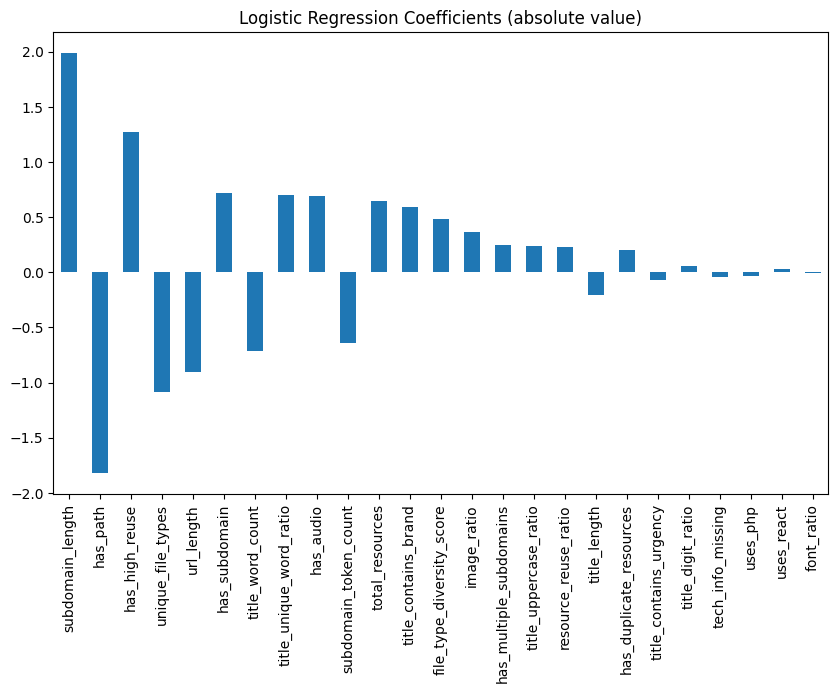

In [ ]:
coefficients = pd.Series(lr.coef_[0], index=X.columns).sort_values(key=abs, ascending=False)
plt.figure(figsize=(10,6))
coefficients.plot(kind="bar")
plt.title("Logistic Regression Coefficients (absolute value)")
plt.show()


In [ ]:
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

print("=== Random Forest ===")
print(classification_report(y_test, y_pred_rf))


=== Random Forest ===
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      6000
           1       0.98      0.96      0.97      5918

    accuracy                           0.97     11918
   macro avg       0.97      0.97      0.97     11918
weighted avg       0.97      0.97      0.97     11918



In [ ]:
xgb = XGBClassifier(n_estimators=200, random_state=42, use_label_encoder=False, eval_metric="logloss")
xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test)

print("=== XGBoost ===")
print(classification_report(y_test, y_pred_xgb))


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [19:42:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


=== XGBoost ===
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      6000
           1       0.97      0.97      0.97      5918

    accuracy                           0.97     11918
   macro avg       0.97      0.97      0.97     11918
weighted avg       0.97      0.97      0.97     11918



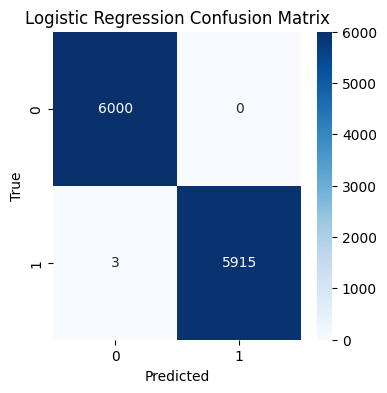

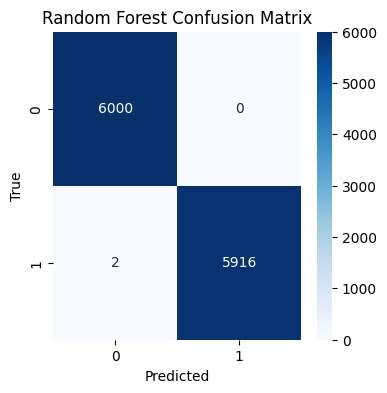

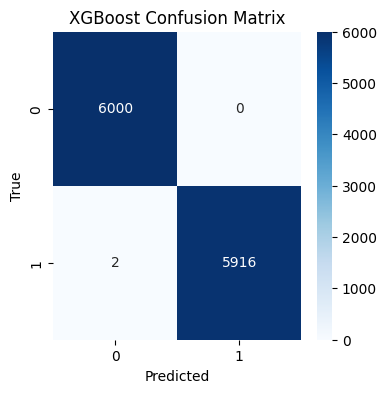

In [ ]:
models = {"Logistic Regression": y_pred_lr, "Random Forest": y_pred_rf, "XGBoost": y_pred_xgb}

for name, y_pred in models.items():
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


# Google use case
We will train a model using google related dataset

In [ ]:
import tldextract

def fqdn_to_brand(fqdn: str) -> str | None:
    if not fqdn:
        return None

    ext = tldextract.extract(fqdn)
    return ext.domain.lower() if ext.domain else None


In [ ]:
benign['brand']=benign['fqdn'].apply(fqdn_to_brand)
benign_google = benign[benign["brand"] == "google"].copy()

In [ ]:
benign_google['label']=0

In [ ]:
benign_google.head()

,url,is_https,dns_a_status,dns_a_answer_1,dns_aaaa_status,dns_mx_status,ssl_issuer,ssl_valid_from,ssl_valid_until,ssl_is_valid_cert,...,sd_has_ip,attack_pattern_ip,has_history,subdomain_len,tld,is_common_tld,trg,fqdn,brand,label
75,https://google.com.bd,True,NOERROR,142.250.181.227,NOERROR,NOERROR,Google Trust Services,2025-01-27,2025-04-21,True,...,0,0,0,4,bd,0,NaN,google.com.bd,google,0
76,https://google.com.vc,True,NOERROR,172.217.16.195,NOERROR,NOERROR,Google Trust Services,2025-01-27,2025-04-21,True,...,0,0,0,4,vc,0,NaN,google.com.vc,google,0
87,https://accounts.google.com/gsi/client?hl=en,True,NOERROR,74.125.206.84,NOERROR,NOERROR,Google Trust Services,2025-01-20,2025-04-14,True,...,1,0,0,8,com,1,NaN,accounts.google.com,google,0
152,https://accounts.google.com/ServiceLogin?hl=fr,True,NOERROR,142.251.168.84,NOERROR,NOERROR,Google Trust Services,2025-01-27,2025-04-21,True,...,1,0,0,8,com,1,NaN,accounts.google.com,google,0
176,https://google.bj,True,NOERROR,142.250.74.195,NOERROR,NOERROR,Google Trust Services,2025-01-27,2025-04-21,True,...,0,0,0,4,bj,0,NaN,google.bj,google,0


In [ ]:
phishing_google = phishing[phishing["trg"] == "google"].copy()
phishing_google['brand']="google"
phishing_google['label']=1
phishing_google.head()

,url,is_https,dns_a_status,dns_a_answer_1,dns_aaaa_status,dns_mx_status,ssl_issuer,ssl_valid_from,ssl_valid_until,ssl_is_valid_cert,...,sd_has_ip,attack_pattern_ip,has_history,subdomain_len,tld,is_common_tld,trg,fqdn,brand,label
3223,https://z5nz7.ushorupt.com/52u3/,True,NOERROR,188.114.96.3,NOERROR,NOERROR,Let's Encrypt,2024-06-10,2024-09-08,True,...,1,1,0,5,com,1,google,z5nz7.ushorupt.com,google,1
3335,https://targobank.de.chateaupuit.fr/auth/,True,NOERROR,103.198.26.251,NOERROR,NOERROR,NaN,NaN,NaN,False,...,1,0,0,12,fr,1,google,targobank.de.chateaupuit.fr,google,1
5495,https://fliiapl.page.link/RtQw,True,NOERROR,216.58.206.65,NOERROR,NOERROR,Google Trust Services,2024-06-24,2024-09-16,True,...,1,0,0,7,link,0,google,fliiapl.page.link,google,1
5724,https://m.rete.service.104-168-136-238.cprapid...,True,NOERROR,104.168.136.238,NOERROR,NOERROR,NaN,NaN,NaN,False,...,1,1,0,30,com,1,google,m.rete.service.104-168-136-238.cprapid.com,google,1
6248,https://m.rete.service.104-168-136-238.cprapid...,True,NOERROR,104.168.136.238,NOERROR,NOERROR,NaN,NaN,NaN,False,...,1,1,0,30,com,1,google,m.rete.service.104-168-136-238.cprapid.com,google,1


In [ ]:
# Combine datasets
combined_df = pd.concat(
    [phishing_google, benign_google],
    axis=0,
    ignore_index=True
)

# Optional: shuffle rows
combined_df = combined_df.sample(frac=1, random_state=42).reset_index(drop=True)

print(combined_df.shape)
combined_df.head()


(973, 54)


,url,is_https,dns_a_status,dns_a_answer_1,dns_aaaa_status,dns_mx_status,ssl_issuer,ssl_valid_from,ssl_valid_until,ssl_is_valid_cert,...,sd_has_ip,attack_pattern_ip,has_history,subdomain_len,tld,is_common_tld,trg,fqdn,brand,label
0,https://google.com.bd,True,NOERROR,142.250.181.227,NOERROR,NOERROR,Google Trust Services,2025-01-27,2025-04-21,True,...,0,0,0,4,bd,0,NaN,google.com.bd,google,0
1,https://www.google.com.cu/intl/fr_fr/ads/?subi...,True,NOERROR,172.217.16.195,NOERROR,NOERROR,Google Trust Services,2025-01-27,2025-04-21,True,...,1,0,0,3,cu,0,NaN,www.google.com.cu,google,0
2,https://www.echulj.cn/,True,NOERROR,43.134.99.93,NOERROR,NOERROR,Let's Encrypt,2024-07-23,2024-10-21,True,...,1,1,0,3,cn,0,google,www.echulj.cn,google,1
3,https://accounts.google.com/ServiceLogin?hl=fr,True,NOERROR,74.125.206.84,NOERROR,NOERROR,Google Trust Services,2025-01-20,2025-04-14,True,...,1,0,0,8,com,1,NaN,accounts.google.com,google,0
4,https://allegrolokalnie.kategorie-ogrody.pl/of...,True,NOERROR,188.114.97.3,NOERROR,NOERROR,Google Trust Services,2024-07-18,2024-10-16,True,...,1,0,0,15,pl,0,google,allegrolokalnie.kategorie-ogrody.pl,google,1


In [ ]:
url_df = url_features(combined_df)
title_df = title_features(combined_df)
ratio_df = resource_ratio_features(combined_df)
dominance_df = resource_dominance_features(combined_df)
complexity_df = resource_complexity_features(combined_df)
tech_df = tech_features(combined_df)


In [ ]:
# Select numeric / ratio features
numeric_features = [
    "url_length",
    "subdomain_length",
    "subdomain_token_count",
    "css_ratio",
    "image_ratio",
    "video_ratio",
    "font_ratio",
    "title_length",
    "title_word_count",
    "title_unique_word_ratio",
    "title_uppercase_ratio",
    "title_digit_ratio",
    "resource_reuse_ratio",
    "file_type_diversity_score",
    "total_resources",
    "unique_file_types",
]

# Boolean features from EDA + original dataset
boolean_features = [
    "title_contains_brand",
    "title_contains_urgency",
    "has_high_reuse",
    "uses_php",
    "has_path",
    "has_duplicate_resources",
    "has_video",
    "has_audio",
    "has_subdomain",
    "trg_mismatch"
]

# Merge all features
final_df = pd.concat(
    [
        combined_df[["label"]],
        url_df,          # url_length, subdomain_length, subdomain_token_count
        title_df[["title_length", "title_word_count", "title_unique_word_ratio",
                  "title_uppercase_ratio", "title_digit_ratio",
                  "title_contains_brand", "title_contains_urgency"]],
        ratio_df[[ "image_ratio", "font_ratio"]],
        complexity_df[["resource_reuse_ratio", "has_high_reuse"]],
        tech_df[["uses_php","uses_react","tech_info_missing"]],
        combined_df[["has_path", "has_duplicate_resources",  "has_audio", "has_subdomain"]],
        combined_df[["total_resources", "unique_file_types", "file_type_diversity_score"]],
    ],
    axis=1
)

print(final_df.shape)
final_df.head()


(973, 26)


,label,url_length,subdomain_length,subdomain_token_count,has_multiple_subdomains,title_length,title_word_count,title_unique_word_ratio,title_uppercase_ratio,title_digit_ratio,...,uses_php,uses_react,tech_info_missing,has_path,has_duplicate_resources,has_audio,has_subdomain,total_resources,unique_file_types,file_type_diversity_score
0,0,26,13,3,True,6,1,1.0,0.166667,0.0,...,False,False,True,False,True,False,False,47,19,0.404
1,0,155,17,4,True,19,3,1.0,0.052632,0.0,...,False,False,False,True,True,False,True,33,13,0.394
2,1,25,13,3,True,6,1,1.0,0.166667,0.0,...,False,False,True,False,True,False,True,31,18,0.581
3,0,226,19,3,True,26,4,1.0,0.076923,0.0,...,False,False,True,True,True,False,True,52,19,0.365
4,1,23,35,3,True,6,1,1.0,0.166667,0.0,...,False,False,True,True,True,False,True,30,18,0.600


In [ ]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 973 entries, 0 to 972
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   label                      973 non-null    int64  
 1   url_length                 973 non-null    int64  
 2   subdomain_length           973 non-null    int64  
 3   subdomain_token_count      973 non-null    int64  
 4   has_multiple_subdomains    973 non-null    bool   
 5   title_length               973 non-null    int64  
 6   title_word_count           973 non-null    int64  
 7   title_unique_word_ratio    973 non-null    float64
 8   title_uppercase_ratio      973 non-null    float64
 9   title_digit_ratio          973 non-null    float64
 10  title_contains_brand       973 non-null    bool   
 11  title_contains_urgency     973 non-null    bool   
 12  image_ratio                973 non-null    float64
 13  font_ratio                 973 non-null    float64

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Target
y = final_df["label"]

# Features
X = final_df.drop(columns=["label"])


In [ ]:
# Convert all boolean columns to int
bool_cols = X.select_dtypes(include="bool").columns
X[bool_cols] = X[bool_cols].astype(int)


In [ ]:
# Numeric columns (float or int, excluding boolean features)
numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns.difference(bool_cols)

scaler = StandardScaler()
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training set:", X_train.shape)
print("Test set:", X_test.shape)


Training set: (778, 25)
Test set: (195, 25)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

print("=== Random Forest ===")
print(classification_report(y_test, y_pred_rf))


=== Random Forest ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       155
           1       1.00      1.00      1.00        40

    accuracy                           1.00       195
   macro avg       1.00      1.00      1.00       195
weighted avg       1.00      1.00      1.00       195



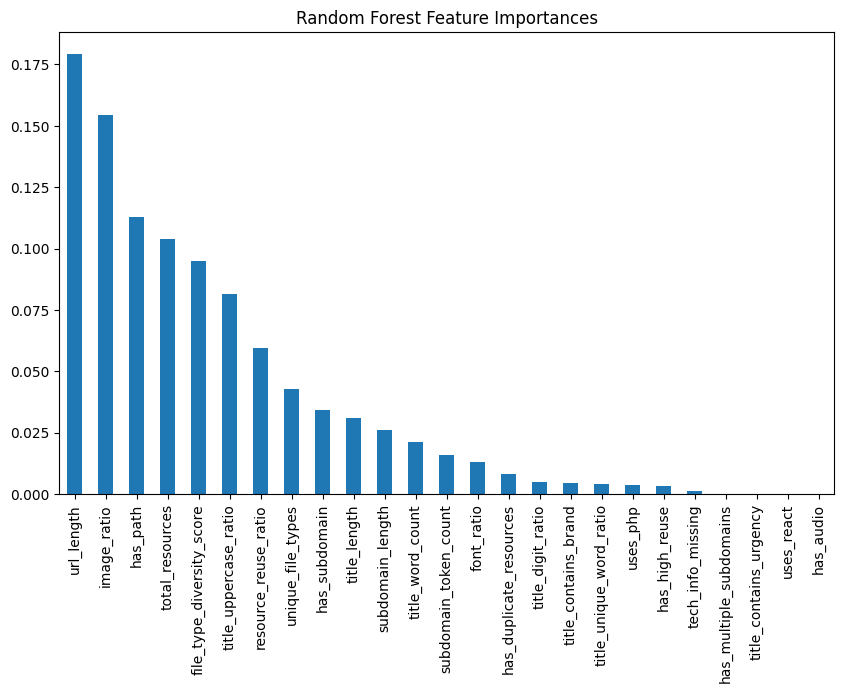

In [ ]:
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10,6))
importances.plot(kind="bar")
plt.title("Random Forest Feature Importances")
plt.show()
